# Binary Classification of Brain Tumours using a Support Vector Machine (SVM) with SIFT feature extraction and k-Means clustering.

For more information on the background of this notebook, please see README.md and the supplementary report. A summary of the entire workflow of this notebook and the motivation behind it is given there.

In [5]:
# Utility libraries
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

# Machine learning and image management libraries
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

The cell below defines key constants of the notebook below. These are free to be changed

The data is loaded from locations relative this directory. Change the dataset location as necessary below.
The below two cells work under the assumption that the filenames and labels located in 'label.csv' exactly match the images found in the 'images' directory, for both the dataset and the external test set.

In [6]:
# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
DATASET_LOCATION = "..\\..\\Assignment Kit\\dataset\\images\\"
DATASET_LABEL_LOCATION = "..\\..\\Assignment Kit\\dataset\\label.csv"

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
TEST_SET_LOCATION = "..\\..\\Assignment Kit\\test_set\\images\\"
TEST_SET_LABEL_LOCATION = "..\\..\\Assignment Kit\\test_set\\label.csv"

# The directory in which to store pre-processed images, or the directoy in which
# pre-processed images will be found if they have already been pre-processed.
PROCESSED_DATASET_LOCATION = "..\\..\\Assignment Kit\\dataset\\processed_images\\"

# Defines range of K values (hyperparameter) to try.
# Number of K values tried is (STOP - START) / STEP.
# Syntax is np.arange(START, STOP, STEP)
# STOP is not inclusive hence increment it by STEP to ensure it is in included.
K_VALS = np.arange(10, 100 + 10, 10).tolist()

# Defines range of hyperparamter for regularisation C = 1 / \lambda used when cross validating SVMs.
C_VALS = np.arange(0.001, 0.08 + 0.001, 0.001).tolist()

print("#K_VALS = {}. K_VALS = {}.".format(len(K_VALS), K_VALS))
print("#C_VALS = {}. C_VALS = {}.".format(len(C_VALS), C_VALS))

#K_VALS = 10. K_VALS = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100].
#C_VALS = 80. C_VALS = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002, 0.011, 0.012, 0.013000000000000001, 0.014000000000000002, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019000000000000003, 0.02, 0.021, 0.022000000000000002, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027000000000000003, 0.028, 0.029, 0.030000000000000002, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037000000000000005, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044000000000000004, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051000000000000004, 0.052000000000000005, 0.053000000000000005, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059000000000000004, 0.060000000000000005, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.07100000000000001, 0.07200000000000001, 0.07300000000000001, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08].


In [7]:
# Loads data into numpy array of strings.
# Header is skipped as given by skip_header = 1.
# The header in the expected file is "file_name" and "label".
# Therefore, indexing the 0'th element in a row references the filenames and indexing the 1'th element in a row references the label

data = np.genfromtxt(DATASET_LABEL_LOCATION, delimiter = ',', dtype = str, skip_header = 1)

# As this a binary classification task, we can rename all labels which are not 'no_tumor' to 'tumor'.
# This will prevent many further comparisons in future.
for i in range(data.shape[0]):
    if (data[i][1] != "no_tumor"):
        data[i][1] = "tumor"

print("There are {} images in the dataset.".format(data.shape[0]))

There are 3000 images in the dataset.


## Data Pre-Processing

The images in the dataset are given as RGB images. This means that each pixel has three corresponding values due to the three colour channels. In the analysis given here, only the greyscale images are needed. That is, each pixel only has one corresponding due to the single colour channel. To enforce this, we pre-process the images to save them in greyscale format. These are then saved in an alternate directory as given by `PROCESSED_DATASET_LOCATION`.

Additionally, the SIFT functionality as implemented by `sklearn` only accepts single colour channel images of unsigned 8 bit datatype. Therefore, the images formed below are normalised as such. Min-Max normalisation here is used with relative safety as much of the dataset does not include spikes in intensity that would force the normaliser to fully normalise any details away. However, this method can lead to some images in the dataset being more 'illuminated' than others. Even though this is the nature of the un-pre-processed dataset anyways, fortunately the SIFT feature detection method is robust to illumination variation.

To ensure that the images are read correctly after they have been processed, the flag `cv2.IMREAD_GRAYSCALE` must be passed when calling `cv2.imread( ... )`.

In [38]:
if not (os.path.isdir(PROCESSED_DATASET_LOCATION)):
    os.mkdir(PROCESSED_DATASET_LOCATION)

    for i in range(data.shape[0]):
        image_string = "IMAGE_" + str(i).zfill(4)
        
        image = cv2.imread(DATASET_LOCATION + image_string + ".jpg")
        
        # Convert colour image to greyscale
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalise image such that pixel values are unsigned 8 bit
        processed_image = cv2.normalize(grey_image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
        
        cv2.imwrite(PROCESSED_DATASET_LOCATION + image_string + ".jpg", processed_image)
        
        if (i % 100 == 0):
            print("{} images processed.".format(i))
            
    print("Image processing done! {} images were processed!".format(data.shape[0]))
    
else:
    print("Data has already been pre-processed!")

Data has already been pre-processed!


Now, we output some random examples from the dataset just to visualise what we are working with. Feel free to run the cell multiple times to see more images in the dataset.

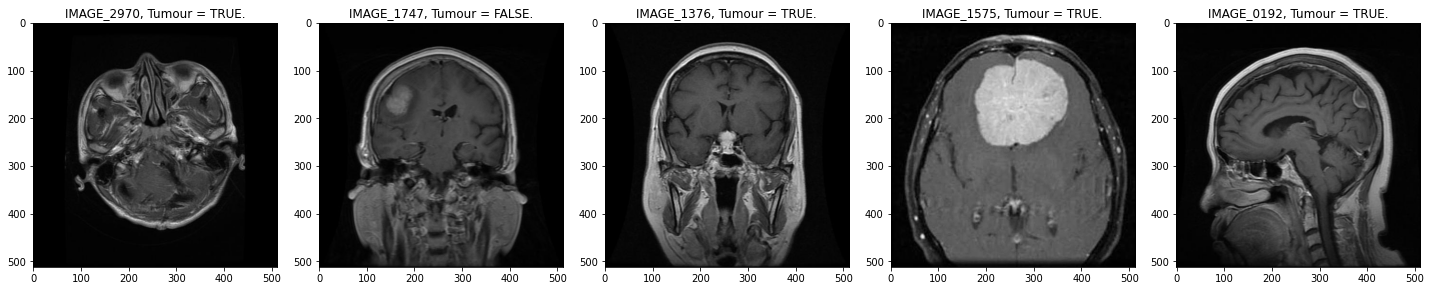

In [44]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for i in range(5):
    image_num = np.random.randint(0, data.shape[0] - 1)
    image_string = "IMAGE_" + str(image_num).zfill(4)
    
    ax[i].imshow(cv2.imread(PROCESSED_DATASET_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE), cmap = "gray")
    ax[i].set_title("{}, Tumour = {}.".format(image_string, "TRUE" if (data[i][1] != "no_tumor") else "FALSE"))
    
plt.tight_layout()

## SIFT Feature Extraction

Here, the SIFT framework is used to extract SIFT keypoints and their corresponding descriptors from the images in the dataset.

There are a few free/hyper parameters that are available for exploration. These parameters include the SIFT parameters: the number of octaves, the number of scale levels, the standard deviation used in the Laplacian of Gaussian (LoG) operation $\sigma$, and others. Another hyperparameter is the number of centroids/cluster's provided to the k-Means clustering algorithm $K$. This hyperparameter $K$ is the only hyperparameter explored here due to the SIFT parameters exerting significantly less influence on the final accuracy when compared to $K$.


The first cell below is configured to provide an example of the features extracted from an example image in the (processed) dataset.

In [78]:
# Set this to False to prevent an example feature detection image being shown.
SHOW_SIFT_FEATURE_EXTRACTION_EXAMPLE = True

634 key points found.


In [ ]:
def buildSet(data):
    # Given a (N \times 2) numpy array with the first column containing the filenames of the images
    # and the second row containing the images labels (as given with the data for this task),
    # this function returns a list of the descriptors of the features found from images in the dataset.
    
    for i in range(data.shape[0]):
        image = cv2.imread(PROCESSED_DATASET_LOCATION + "IMAGE_" + str(i).zfill(4) + ".jpg", cv2.IMREAD_GRAYSCALE)
        
        key_points = sift.detect(image, mask = None)

In [ ]:
sift = cv2.SIFT_create()

#for k in K_VALS:
if (True):
    k = 10
    
    # Show example if flag above is TRUE, but only show it once.
    if (SHOW_SIFT_FEATURE_EXTRACTION_EXAMPLE and (k == K_VALS[0])):
        image_string = "IMAGE_" + str(np.random.randint(0, data.shape[0] - 1)).zfill(4)
        
        image = cv2.imread(PROCESSED_DATASET_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE)
        
        key_points = sift.detect(image, None)
        
        image = cv2.drawKeypoints(image, key_points, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        print("{} key points found in example image \"{}\".".format(len(key_points), image_string))
        
        plt.imshow(image)
    
    # Build training dataset
    train_set = buildSet(data)
        
        